In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_india_diabetes = pd.read_excel('../Case/ICMR-INDIAB Study.xlsx')
data_india_population = pd.read_excel('../Case/India Population (2011).xlsx')

In [38]:
list(data_india_diabetes)

['State',
 'Diabetes',
 'Prediabetes',
 'Hypertension',
 'Generalized Obesity',
 'Abdominal Obesity',
 'Source']

In [ ]:
data1 = pd.read_excel('../Case/ICMR-INDIAB Study.xlsx')

In [106]:
data_india_diabetes = pd.read_excel('../Case/ICMR-INDIAB Study.xlsx')

get_lower = lambda x: [float(i.split(" ")[1][1:-1].split("–")[0]) for i in x]
get_upper = lambda x: [float(i.split(" ")[1][1:-1].split("–")[1]) for i in x]
get_mean = lambda x: [float(i.split(" ")[0]) for i in x]

def add_cols(data,cols):
    for col in cols:
        data.insert(1, f"{col} Max", get_upper(data[col]))
        data.insert(1, f"{col} Min", get_lower(data[col]))
        data.insert(1, f"{col} Mean", get_mean(data[col]))
        data.drop(col, axis=1, inplace=True)
    return data
data3 = add_cols(data_india_diabetes, ["Abdominal Obesity", "Generalized Obesity", "Hypertension", "Prediabetes", "Diabetes"])
data3.to_excel("ICMR-INDIAB_modified.xlsx")

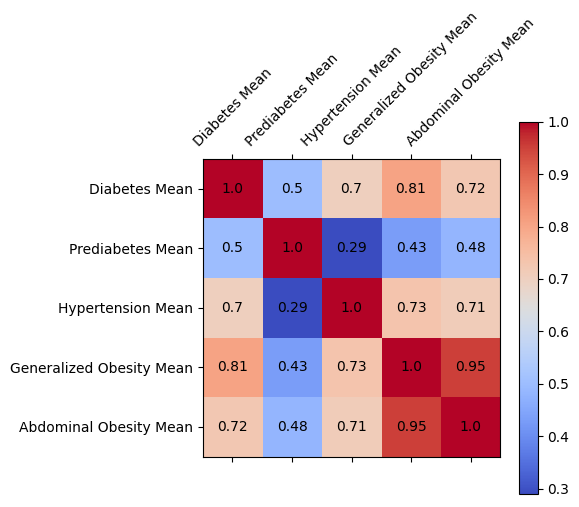

In [130]:
data1 = pd.read_excel("ICMR-INDIAB_modified.xlsx", index_col=0)
cols = ["Diabetes Mean", "Prediabetes Mean", "Hypertension Mean", "Generalized Obesity Mean", "Abdominal Obesity Mean"]
# with cols as labels:
plt.matshow(data1[cols].corr(), cmap='coolwarm')
plt.yticks(range(len(cols)), cols, rotation=0);
plt.xticks(range(len(cols)), cols, rotation=45);
# include numbers in the heatmap
for i in range(len(cols)):
    for j in range(len(cols)):
        plt.text(j, i, round(data1[cols].corr().values[i, j], 2), ha='center', va='center', color='black')
# make legend
plt.colorbar();

In [74]:
data_india_population#.iloc[1][[-3,-2,-1]]

data2 = data_india_population[data_india_population["Rural/Urban"] == "Urban"]

for name in list(data_india_diabetes["State"]):
    
    try:
        print(name, f'{float(data2[data2["Name"] == name.upper()]["Population"]) * float(data_india_diabetes[data_india_diabetes["State"] == name]["Diabetes Mean"]):.2E}')
    except:
        print(name)

Andhra Pradesh 2.68E+08
Arunachal Pradesh 1.90E+06
Assam 2.95E+07
Bihar 6.35E+07
Chandigarh 2.09E+07
Chhattisgarh 6.12E+07
Delhi
Goa 2.39E+07
Gujarat 2.11E+08
Haryana 1.10E+08
Himachal Pradesh 9.30E+06
Jharkhand 5.71E+07
Karnataka 2.50E+08
Kerala 4.06E+08
Madhya Pradesh 1.42E+08
Maharashtra 5.23E+08
Manipur 5.51E+06
Meghalaya 3.10E+06
Mizoram 4.40E+06
Nagaland 3.43E+06
Odisha 6.79E+07
Puducherry 2.24E+07
Punjab 1.32E+08
Rajasthan 1.16E+08
Sikkim 1.97E+06
Tamil Nadu 5.03E+08
Telangana
Tripura 1.09E+07
Uttar Pradesh 2.14E+08
Uttarakhand 3.38E+07
West Bengal 3.99E+08


In [81]:
print(list(data_india_population["Name"])[::3])

['India', 'JAMMU & KASHMIR', 'HIMACHAL PRADESH', 'PUNJAB', 'CHANDIGARH', 'UTTARAKHAND', 'HARYANA', 'NCT OF DELHI', 'RAJASTHAN', 'UTTAR PRADESH', 'BIHAR', 'SIKKIM', 'ARUNACHAL PRADESH', 'NAGALAND', 'MANIPUR', 'MIZORAM', 'TRIPURA', 'MEGHALAYA', 'ASSAM', 'WEST BENGAL', 'JHARKHAND', 'ODISHA', 'CHHATTISGARH', 'MADHYA PRADESH', 'GUJARAT', 'DAMAN & DIU', 'DADRA & NAGAR HAVELI', 'MAHARASHTRA', 'ANDHRA PRADESH', 'KARNATAKA', 'GOA', 'LAKSHADWEEP', 'KERALA', 'TAMIL NADU', 'PUDUCHERRY', 'ANDAMAN & NICOBAR ISLANDS']
